## DA6401 Assignment 1
#### Achyutha M. - PH21B004

In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from IPython.display import clear_output

from utils import wandb_helper
from utils import helper_functions
from utils import neural_network

In [2]:
wandb_entity = "bullseye2608-indian-institute-of-technology-madras"
wandb_project = "PH21B004_DA6401-Assignment-1"

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bullseye2608 (bullseye2608-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Question 1

In [4]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test = helper_functions.load_data('fashion_mnist')

# Log image examples to wandb
wandb_helper.log_images(X_train, y_train, entity=wandb_entity, project=wandb_project)


### Question 2

In [4]:
# Implemented and initialised the class NeuralNetwork
nn = neural_network.NeuralNetwork(
    layer_sizes=[784, 64, 64, 10],
    activation_functions=['relu', 'relu', 'softmax'],
    weight_decay=0.0,
    weight_init='xavier',
)

# Testing initialised model
y_init_pred = nn.forward_propagation(X_train)[0][-1]
init_accuracy = nn.compute_accuracy_from_predictions(y_init_pred, y_train)

print(f"Accuracy of Neural Network before training: {init_accuracy :<f}")

Accuracy of Neural Network before training: 0.037315


### Question 3

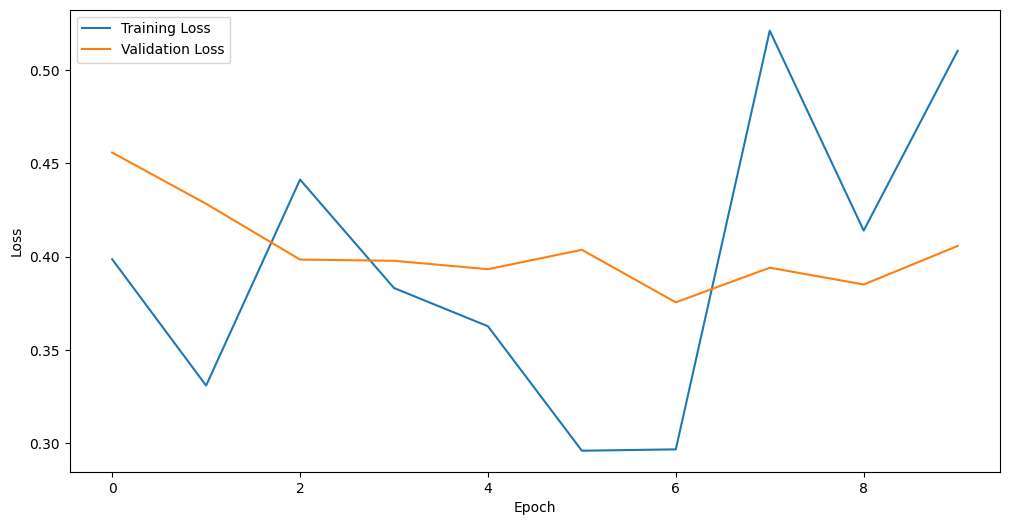

In [5]:
# Training the model
optimizer = {
    'name': 'adam',
    'learning_rate': 0.01,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8
}

nn.set_optimizer(optimizer_dict=optimizer)

history = nn.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=64,
    num_epochs=10,
    loss_type='cross_entropy',
)

nn.plot_history(history)

In [6]:
nn.compute_accuracy(X_val, y_val)

np.float64(0.8583333333333333)

### Question 4

In [ ]:

# Create New sweep
import yaml

with open("sweep_config.yaml", "r") as file:
        sweep_config = yaml.safe_load(file)

run_count = 2
flag_restart_sweep, sweep_id = False, 'g0rcwx3e'

if flag_restart_sweep:
        
        sweep_id = wandb.sweep(sweep_config, 
                entity=wandb_entity,
                project=wandb_project)
        trainer = wandb_helper.WandbTrainer()

        wandb.agent(sweep_id, trainer.train, count=run_count)
        flag_restart_sweep = False
else:
        sweep_id_cont = '/'.join([wandb_entity, wandb_project, sweep_id])
        trainer = wandb_helper.WandbTrainer()
        
        wandb.agent(sweep_id_cont, trainer.train, count=run_count)

wandb.finish()
wandb.teardown()

clear_output(wait=True)
print(f'Succesfully ran sweep of {run_count} runs')

Succesfully ran sweep of 2 runs


### Question 7

In [ ]:
# Run the optimal model configuration multiple times
def run_multiple_experiments(variation, log_aggregate_confusion_matrix=True):
    
    
    X_train, y_train, X_val, y_val, X_test, y_test = helper_functions.load_data('fashion_mnist')
    
    
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # Lists to store results from all runs
    all_metrics = []
    all_cms = []
    all_y_preds = []
    run_ids = []
    
    # Create a group ID for all runs
    group_id = f"optimal-config-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    # Set changes in runs
    
    num_runs = len(variation)
    
    # Run the model multiple times
    for run_id in range(num_runs):
        print(f'Run {run_id+1} of {num_runs}')
        # Set a different random seed for each run
        np.random.seed(42 + run_id)
        config = helper_functions.OptimalConfig(**variation[run_id])
        
        # Initialize a new wandb run
        run = wandb.init(
            entity=wandb_entity,
            project=wandb_project,
            name=f"optimal-run-{run_id+1}",
            tags=["optimal-config"],
            group=group_id,
            config=config,
            reinit=True
        )
            # wandb.config.update(config)
        config.print_config()
        
        
        layer_sizes = [784] + [config.hidden_size]*config.num_layers + [10]
        activation_functions = [config.activation]*config.num_layers + ['softmax']
        
        nn = neural_network.NeuralNetwork(layer_sizes=layer_sizes, 
                        activation_functions=activation_functions,
                        weight_init=config.weight_init, 
                        weight_decay=config.weight_decay)
        
        wandb_callback = wandb_helper.WandbCallback()
        
        optimizer = helper_functions.get_optimizer(config.optimizer, config.learning_rate)
        nn.set_optimizer(optimizer)
        
        nn.train(
            X_train,
            y_train,
            X_val,
            y_val,
            batch_size=config.batch_size,
            num_epochs=config.epochs,
            loss_type=config.loss,
            log_every=1000,
            callback=wandb_callback
        )
        
        test_accuracy = nn.compute_accuracy(X_val, y_val)
        wandb.log({"test_accuracy": test_accuracy})
        
        # Evaluate the model
        test_loss = nn.compute_loss(nn.predict(X_val), y_val)
        test_acc = nn.compute_accuracy(X_val, y_val)
        
        # Get predictions
        y_pred_probs = nn.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Store predictions
        all_y_preds.append(y_pred)
        
        # Create and log confusion matrix
        cm_file, cm, precision, recall, f1 = helper_functions.plot_confusion_matrix(y_val, y_pred, run_id)
        all_cms.append(cm)
        
        # Log confusion matrix image
        wandb.log({"confusion_matrix": wandb.Image(cm_file)})
        
        # Log interactive confusion matrix
        wandb.log({"confusion_matrix_plot": wandb.plot.confusion_matrix(
            probs=y_pred_probs,
            y_true=y_val,
            class_names=class_names
        )})
        
        # Log metrics
        run_metrics = {
            'test_loss': test_loss,
            'test_accuracy': test_acc,
            'run_id': run_id + 1
        }
    
        
        # Log all metrics
        wandb.log(run_metrics)
        
        # Store metrics for aggregate analysis
        all_metrics.append(run_metrics)
        run_ids.append(run.id)
        
        
        # Finish the run
        wandb.finish()
        clear_output(wait=True)
    
    if log_aggregate_confusion_matrix:
        # Create an aggregate analysis run
        run = wandb.init(
            project="confusion_matrix_trials",
            name=f"aggregate-analysis-{num_runs}-runs",
            tags=["aggregate", "analysis", group_id],
            group=group_id
        )
        
        # Calculate average confusion matrix
        avg_cm = np.mean(all_cms, axis=0)
        std_cm = np.std(all_cms, axis=0)
        
        # Create and log aggregate confusion matrix
        plt.figure(figsize=(12, 10))
        avg_cm_normalized = avg_cm.astype('float') / avg_cm.sum(axis=1)[:, np.newaxis]
        
        fig = helper_functions.create_plotly_confusion_matrix(avg_cm, class_names, run_id=0)
        
        helper_functions.log_plotly_confusion_matrix_to_wandb(fig, run_id=0)
        
        
        avg_cm_df = pd.DataFrame(avg_cm_normalized, index=class_names, columns=class_names)
        
        sns.heatmap(avg_cm_df, annot=True, fmt='.2f', cmap='viridis', 
                    linewidths=.5, cbar_kws={"shrink": .8})
        
        # Calculate aggregate metrics
        accuracies = [m['test_accuracy'] for m in all_metrics]
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        
        plt.title(f'Aggregate Confusion Matrix (17 Runs)\nMean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}', fontsize=16)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # Save and log the aggregate confusion matrix
        agg_cm_file = "./helper_plots/aggregate_confusion_matrix.png"
        plt.savefig(agg_cm_file, dpi=300, bbox_inches='tight')
        plt.show()
        
        wandb.log({"aggregate_confusion_matrix": wandb.Image(agg_cm_file)})
        
        # Log aggregate metrics
        agg_metrics = {
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'min_accuracy': min(accuracies),
            'max_accuracy': max(accuracies),
            'num_runs': num_runs
        }
        
        # Create a summary table with links to all runs
        run_table = wandb.Table(columns=["Run ID", "Accuracy"])
        for i, (run_id, metrics) in enumerate(zip(run_ids, all_metrics)):
            run_table.add_data(i+1, metrics['test_accuracy'])
        
        wandb.log({"runs_summary": run_table})
        wandb.log(agg_metrics)
        
        # Finish the aggregate run
        wandb.finish()
    
    return all_metrics, all_cms, all_y_preds, agg_cm_file

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

variation = [
        {},
        # {'loss': 'mean_squared_error'},
        {'batch_size': 32, 'num_layers': 4},
        {'epochs':15, 'batch_size': 128, 'num_layers': 5},
    ]


_, _, _, agg_cm_file = run_multiple_experiments(variation=variation, log_aggregate_confusion_matrix=True)

clear_output(wait=True)
img_read = mpimg.imread(agg_cm_file)
plt.show()
print("All runs completed!")

All runs completed!


### Question 8

In [ ]:
# Lists to store models and histories
ce_models = []
mse_models = []
ce_histories = []
mse_histories = []

num_runs = 5

# Run each model num_runs times
config_1 = helper_functions.OptimalConfig()
config_2 = helper_functions.OptimalConfig(loss='mean_squared_error', batch_size=32, optimizer='rmsprop')
epochs = config_1.epochs

X_train, y_train, X_val, y_val, X_test, y_test = helper_functions.load_data('fashion_mnist')

for i in tqdm(range(num_runs)):
    # Train CE model
    nn_ce, history_ce = neural_network.nn_from_config(config=config_1, 
                                        wandb_callback=None, 
                                        X_train=X_train, 
                                        y_train=y_train, 
                                        X_val=X_val, 
                                        y_val=y_val)
    ce_models.append(nn_ce)
    ce_histories.append(history_ce)
    
    # Train MSE model
    nn_mse, history_mse = neural_network.nn_from_config(config=config_2, 
                                        wandb_callback=None, 
                                        X_train=X_train, 
                                        y_train=y_train, 
                                        X_val=X_val, 
                                        y_val=y_val)
    mse_models.append(nn_mse)
    mse_histories.append(history_mse)

100%|██████████| 5/5 [03:43<00:00, 44.76s/it]


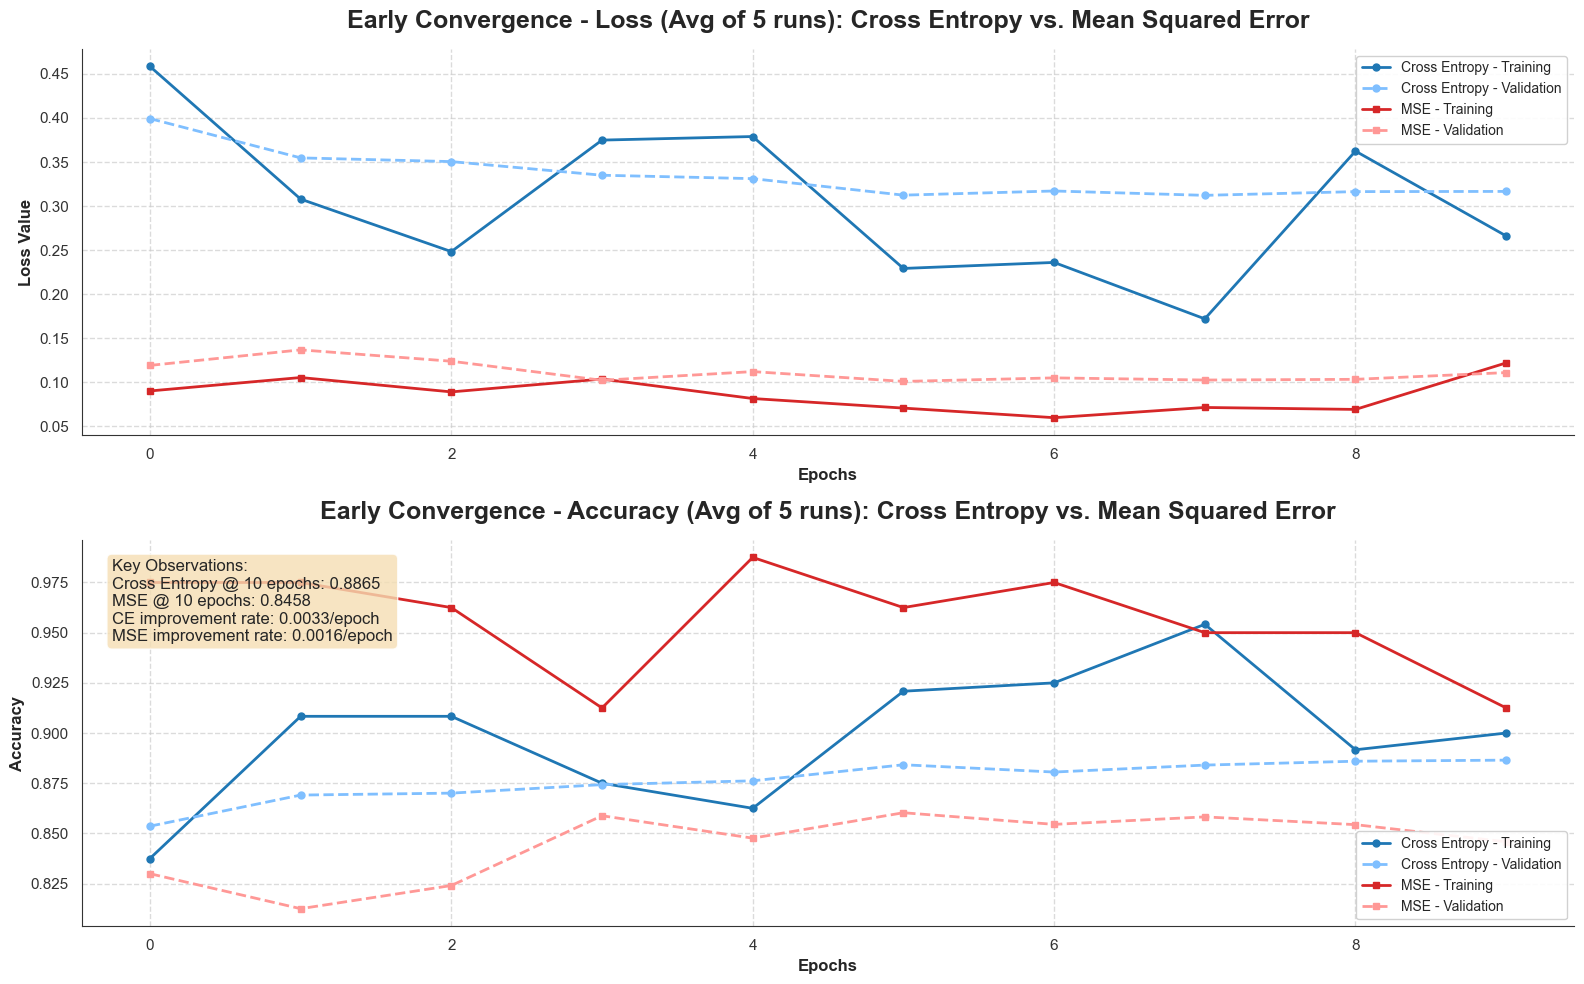

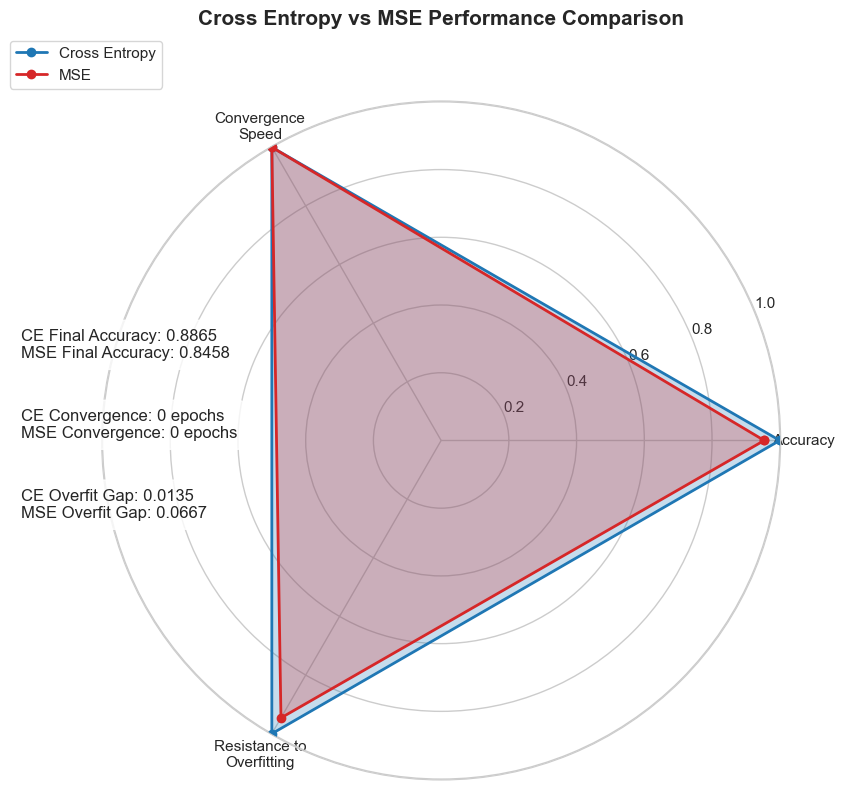

=== CROSS ENTROPY VS MSE COMPARISON ===
Final Cross Entropy Validation Accuracy: 0.8865
Final MSE Validation Accuracy: 0.8458

Convergence Speed (epochs to reach 90% of final accuracy):
Cross Entropy: 0
MSE: 0

Overfitting Assessment (train_acc - val_acc):
Cross Entropy: 0.0135
MSE: 0.0667

=== CONCLUSION ===
Best for Accuracy: Cross Entropy
Best for Convergence Speed: MSE
Best for Avoiding Overfitting: Cross Entropy


In [ ]:
results = helper_functions.plot_loss_comparison(
    ce_histories=ce_histories,
    ce_models=ce_models,
    mse_histories=mse_histories,
    mse_models=mse_models,
    epochs=config_1.epochs
)